In [1]:
from __future__ import division
%matplotlib inline
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from model_fit import *
import seaborn as sb

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


El paquete de seaborn puede ser omitido.

In [2]:
model = 'gaussian'

Datasets.
Los datos: dataset8 y mock3 se generaron apartir del script sinthetic_data.py

Los valores reales de los parametros son: 100., 80.,10., 7.5, -2.55, 0.1

In [3]:
frqs, T_sky ,sigma = np.loadtxt('dataset8.txt', unpack = True)
#frqs, T_sky ,sigma = np.loadtxt('mock3.txt', unpack = True)

"scihi_fore.txt"  son los datos obtenidos de la colaboracion mediante el uso de plot_digitizer

In [4]:
#frqs, T_sky = np.loadtxt('scihi_fore.txt', unpack=True)
#sigma = radiometer(T_sky, 0.83, np.diff(frqs)[0])
#sigma = sigma*1e2 #agregar este factor para tratar de compesar el sobreajuste

"calibrated_data_1.txt" son los datos calibrados para el intervalo de 60 minutos 

In [5]:
#direction ='/Users/Oleg/documents/SCI-Bayes/avances/'
#T_sky = np.loadtxt(direction+'calibrated_data_1.txt')
#T_sky = 10**T_sky 
#frqs = np.linspace(50,90,len(T_sky))
#sigma= radiometer(T_sky, 1.0, np.diff(frqs)[0])
#sigma = sigma*1e2 #agregar este factor para tratar de compesar el sobreajuste

In [6]:
sb.set_style("white")

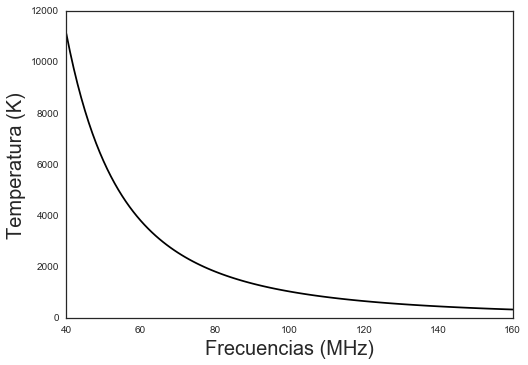

In [7]:
fig = plt.figure()
plt.errorbar(frqs,T_sky,yerr = sigma,c='k')
plt.xlabel('Frecuencias (MHz)', fontsize=20)
plt.ylabel('Temperatura (K)',fontsize=20)
#fig.savefig('/Users/Oleg/documents/latex/tesis/Tesis(draft)/temp_sci.pdf')

In [8]:
print max(frqs), min(frqs)

160.0 40.0


In [9]:
#lista de los priors. Cambia dependeniendo del orden del foreground.
priors_gauss = np.array([0.,1000., min(frqs),max(frqs), 0.,40.,
                         0.,10., -10.,0., -5.,5.])#,-5.,5.])

In [10]:
bnds = ((0.,1000.),(min(frqs),max(frqs)),(0.,40.),(0.,10.)
        ,(-10.,0.),(-5.,5.),(-10.,10.),(-20.,20.))

In [11]:
ndim = int(np.size(priors_gauss)/2)

In [12]:
print ndim

6


In [13]:
mid = np.zeros(ndim)

In [14]:
for i in range(ndim):
    mid[i] = priors_gauss[2*i] + priors_gauss[2*i + 1]

In [15]:
mid = 0.5 * mid

Aqui se calcula el maximo likelihood. Estimación de parámetros

In [16]:
fun = lambda *args: -lnhood(*args)

In [17]:
result = op.minimize(fun, mid, args=(model, T_sky, frqs, sigma), 
                     method = 'L-BFGS-B')

In [18]:
print result.x

[  4.96974079e+02   4.61359482e+01   2.78220898e+01   7.50008337e+00
  -2.55006234e+00   9.98692369e-02]


In [19]:
print result.x[3:]

[ 7.50008337 -2.55006234  0.09986924]


Se compara el resultado de la estimación de parametros con los datos

In [20]:
fore = foreground(frqs)
T_gx2 = fore(round(result.x[3],3),round(result.x[4],3),
             round(result.x[5],3))#,round(result.x[6],3))
            

In [21]:
#t_b = (T_sky - T_gx) * 1000.
t_b2 = (T_sky - T_gx2)

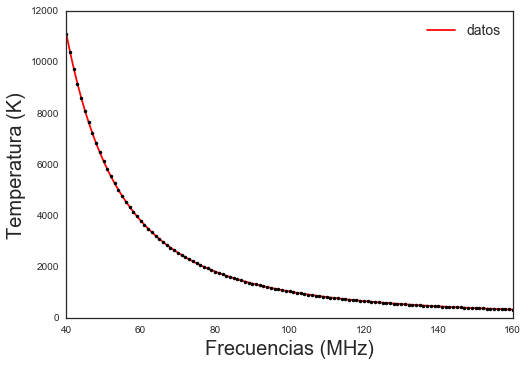

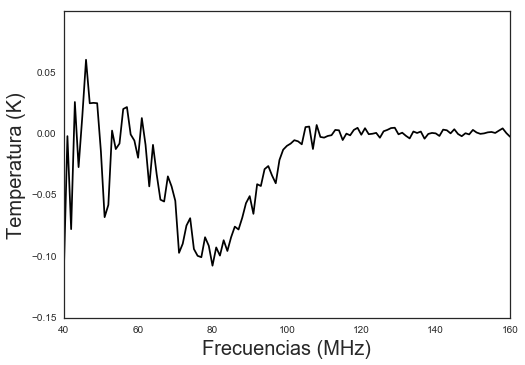

In [22]:
fig1=plt.figure()
plt.plot(frqs, T_gx2,'r',label='datos')
plt.plot(frqs, T_sky,'.k') 
#plt.title('Residuos')
plt.legend(loc='best', fontsize=14)
plt.xlabel('Frecuencias (MHz)', fontsize=20)
plt.ylabel('Temperatura (K)', fontsize =20)
#fig1.savefig('/Users/Oleg/documents/latex/tesis/Tesis(draft)/fit_sci.pdf')
fig21=plt.figure()
plt.plot(frqs,t_b2,'k')
plt.xlabel('Frecuencias (MHz)', fontsize=20)
plt.ylabel('Temperatura (K)', fontsize=20)
#fig21.savefig('/Users/Oleg/documents/latex/tesis/Tesis(draft)/res_sci.pdf')

In [23]:
nwalkers = 300

In [24]:
z = np.zeros((ndim, nwalkers))

Se inicializan los caminadores en posiciones aleatorias cercanas al resultado de la maximización del likelihood

In [25]:
h = 1e-2

pos_i=[]

np.random.seed(0)

for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],z[5,i]]))
    #,z[6,i]]))                         

In [26]:
b_steps, steps = 500, 1500 #pasos del burn in y los pasos para correr emcee

In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(model, T_sky, frqs, sigma, priors_gauss),
                                threads = 2)

In [28]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps) # burn in 

In [29]:
sampler.acceptance_fraction.mean()

0.45951999999999998

In [30]:
sampler.reset()
#se pierde toda las cadenas del burn in excepto la última

In [31]:
_, _, _ = sampler.run_mcmc(pos, steps, rstate0=state)

In [32]:
sampler.acceptance_fraction.mean()

0.51537333333333346

Se imprimen todas las cadenas para los parámetros de la temperatura de brillo

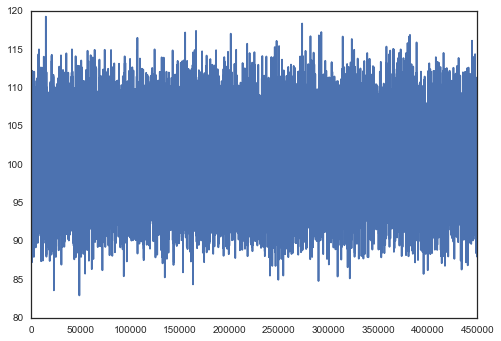

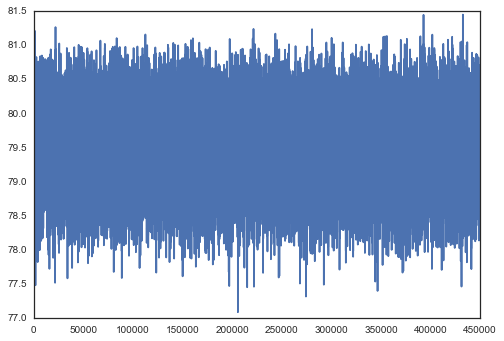

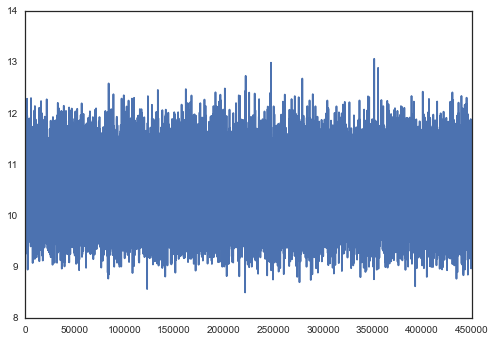

In [33]:
plt.figure()
plt.plot(sampler.flatchain[:,0])
plt.figure()
plt.plot(sampler.flatchain[:,1])
plt.figure()
plt.plot(sampler.flatchain[:,2])

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


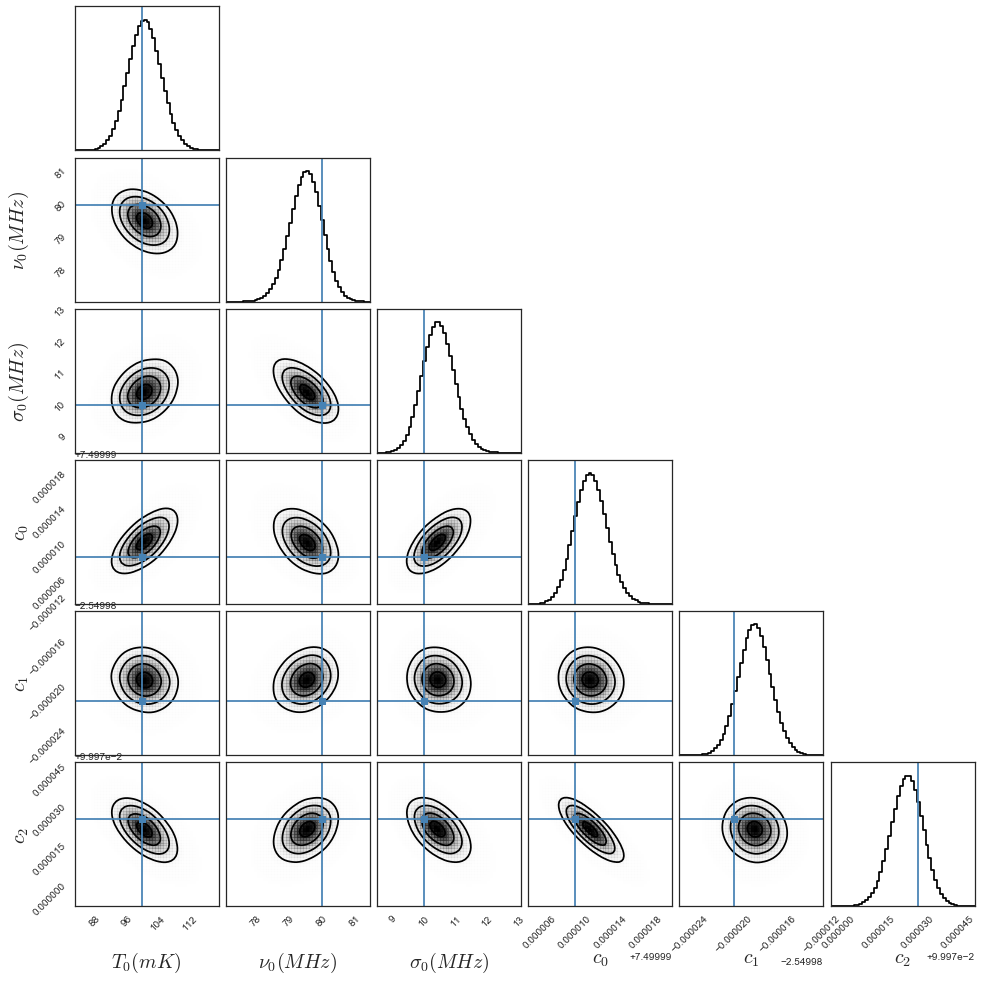

In [34]:
fig1 = corner.corner(sampler.flatchain,labels=[r'$T_0(mK)$',r'$\nu_0(MHz)$',r'$\sigma_0(MHz)$',r'$c_0$',r'$c_1$',r'$c_2$'],
                     label_kwargs={'fontsize':20},bins=50,plot_datapoints=False,smooth=2.,
                     smooth1d=2., truths=[100.,80,10.,7.5,-2.55,0.1]);

In [35]:
#fig2 = corner.corner(sampler.flatchain[:,3:],color='b', plot_datapoints=False)

In [36]:
#fig.savefig('/Users/Oleg/documents/latex/tesis/Tesis(draft)/corner_scihi_n2.pdf')

In [37]:
#np.savetxt('/Users/Oleg/Documents/SCI-Bayes/4th_poly/mcmc_scihi_n2.txt', sampler.flatchain)

Se calculan las funciones de correlacion para los diferentes parámtros del modelo. Esto nos ayuda a concluir se las cadenas convergen o no.

In [38]:
t_corr = np.zeros((nwalkers,steps))                
nu_corr = np.zeros((nwalkers,steps)) 
s_corr = np.zeros((nwalkers,steps)) 

In [39]:
for i in range(nwalkers):
    t_corr[i] = emcee.autocorr.function(sampler.chain[i,:,0],axis=0)
    nu_corr[i] = emcee.autocorr.function(sampler.chain[i,:,1],axis=0)
    s_corr[i] = emcee.autocorr.function(sampler.chain[i,:,2],axis=0)

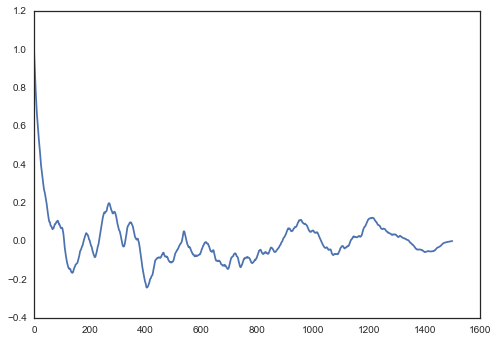

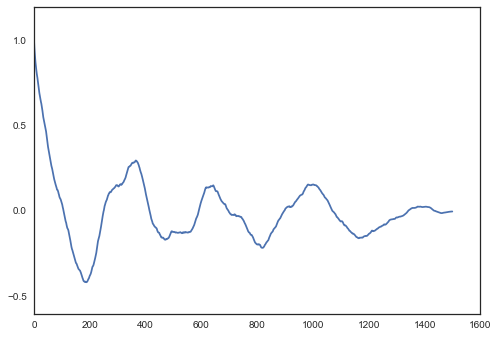

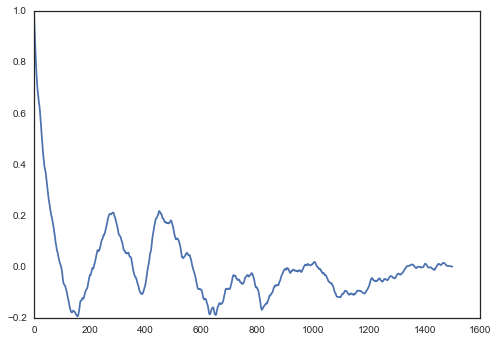

In [40]:
number = 60
plt.figure()
plt.plot(t_corr[number][:])
plt.figure()
plt.plot(nu_corr[number][:])
plt.figure()
plt.plot(s_corr[number][:])

De nuevo se muestran las cadenas; en este caso cada color es una cadena 
individual

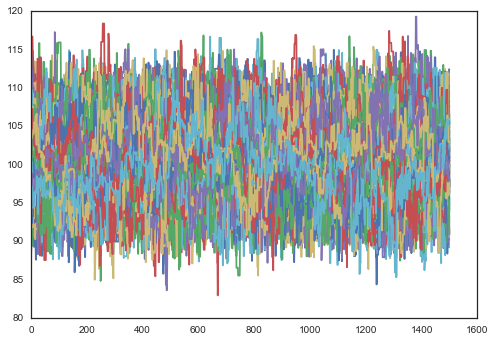

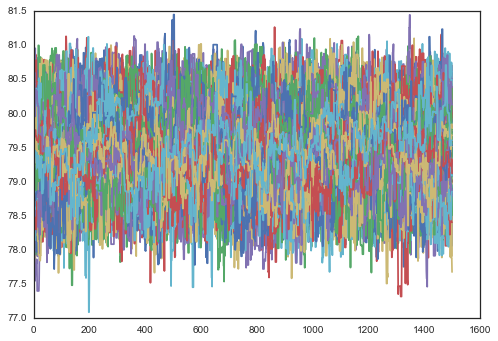

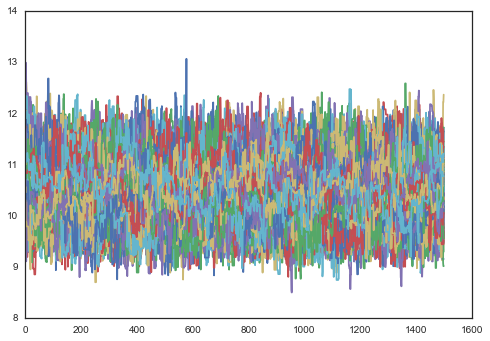

In [41]:
plt.figure()
plt.plot(sampler.chain[:,:,0].T);
plt.figure()
plt.plot(sampler.chain[:,:,1].T);
plt.figure()
plt.plot(sampler.chain[:,:,2].T);

In [42]:
signal = model_21cm(frqs,model) #modelo en model_fit.py

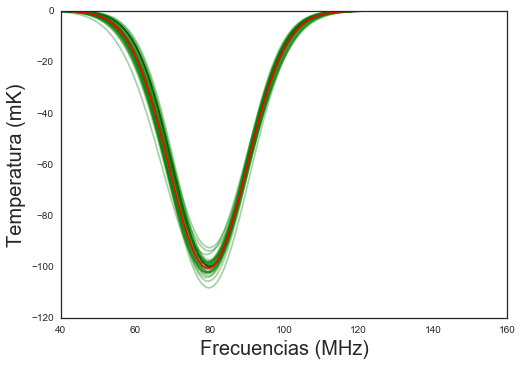

In [43]:
plt.plot(frqs,signal(100.,80.,10.),'k')
#plt.plot(frqs, signal(100., 80.,10.), 'k')
for t, n, s, c1,c2,c3 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=30)]:
    fg2,=plt.plot(frqs,signal(t,n,s),'g', alpha=0.35)

mean_t = np.mean(sampler.flatchain[:,0])
mean_n = np.mean(sampler.flatchain[:,1])
mean_s = np.mean(sampler.flatchain[:,2])
#mean_c1 = np.mean(sampler.flatchain[:,3])
#mean_c2 = np.mean(sampler.flatchain[:,4])
#mean_c3 = np.mean(sampler.flatchain[:,5])

fg3,=plt.plot(frqs, signal(mean_t, mean_n, mean_s), 'r')
#fg4, = plt.plot(frqs, (T_sky-fore(mean_c1, mean_c2, mean_c3))*1000.,'k')
#plt.legend([fg1,fg2,fg3],['Residuos','Muestas Aleatorias', 'Media'],loc='best')
plt.xlabel('Frecuencias (MHz)',fontsize=20)
plt.ylabel('Temperatura (mK)',fontsize=20)
#fig2.savefig('/Users/Oleg/documents/latex/tesis/Tesis(draft)/samples_g.pdf')
